<a href="https://colab.research.google.com/github/Incredible88/FinBERT-fine-tuned/blob/main/Finbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get start

In [1]:
# Import different python libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
!pip install chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import chardet
with open('/content/FOMC_minutes.csv', 'rb') as f:
    result = chardet.detect(f.read())
encoding = result['encoding']

In [ ]:
# To find what encoding type of data
encoding

'Windows-1252'

# Load minutes data

In [ ]:
text = pd.read_csv('https://raw.githubusercontent.com/Incredible88/FinBERT-fine-tuned/main/data/FOMC_minutes.csv',encoding='Windows-1252')

In [ ]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Month     382 non-null    int64 
 1   Day       382 non-null    int64 
 2   Year      382 non-null    int64 
 3   date      382 non-null    object
 4   sentence  382 non-null    object
dtypes: int64(3), object(2)
memory usage: 15.0+ KB


# load Finbert 

In [67]:
!pip install transformers==4.28.1
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = pipeline("text-classification", model=finbert, tokenizer=tokenizer)


## Using spacy to split sentences

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

sentences = []
for text in tqdm(text['sentence']):
    doc = nlp(text)
    for sent in doc.sents:
        sentences.append(sent.text)


100%|██████████| 382/382 [02:47<00:00,  2.28it/s]


# Predict the original dataset


In [ ]:
nlp(sentences_list[1])

[{'label': 'Neutral', 'score': 0.9999871253967285}]

In [ ]:
results = []
for sentence in tqdm(sentences):
    doc = finbert(sentence)
    label = doc[0]['label']
    score = doc[0]['score']
    results.append({'sentence': sentence, 'label': label, 'score': score})

df = pd.DataFrame(results)

100%|██████████| 32330/32330 [1:47:26<00:00,  5.02it/s]


In [ ]:
df.head()

,sentence,label,score
0,The Manager of the System Open Market Account ...,Neutral,0.999998
1,There were no open market operations in foreig...,Neutral,0.999987
2,The Manager also reported on developments in d...,Neutral,0.999989
3,"By unanimous vote, the Committee ratified thes...",Neutral,0.999968
4,The information reviewed at this meeting sugge...,Positive,1.000000


In [ ]:
# Save the results
df.to_csv('FOMC_results.csv', index=False)

# Text Simplification (sentiment focus)

**Step1.**  
To **remove comma** when two paragraph should be together. For Example: 
 
However, the apparent pickup in longer-term expectations, while worrisome, was relatively small  
⇓  
However, the apparent pickup in longer-term expectations, while worrisome was relatively small 

---
**Step2.**  
If there is a transition such as **although**, **though** and **while**, the focus will be on those paragraph except this one, and if there is a **but**, the focus will be on the paragraph containing the but. For example:

**Although** some scattered signs of cooling of the housing sector had emerged, the pace of construction activity and sales remained brisk.  
⇓  
the pace of construction activity and sales remained brisk.

Starts of new single-family homes dropped back somewhat in October from September's very strong pace, **but** permit issuance remained elevated.   
⇓  
permit issuance remained elevated.



In [29]:
import spacy

nlp = spacy.load("en_core_web_sm")

def remove_comma(sentence):
    doc = nlp(sentence)
    indices = []
    for i, token in enumerate(doc):
        if token.dep_ == "punct":
            try:               
                next_token = doc[i+1]
                if next_token.dep_ == "ROOT" or next_token.dep_ == "conj":
                    indices.append(i)
            except IndexError:
                pass
    if not indices:
        return sentence
    else:
        parts = []
        last_idx = 0
        for idx in indices:
            parts.append(doc[last_idx:idx].text.strip())

            last_idx = idx+1
        parts.append(doc[last_idx:].text.strip())
        return " ".join(parts)


In [ ]:
# Example of remove_comma
remove_comma("The personal saving rate--while still slightly negative,moved up in October.")

'The personal saving rate--while still slightly negative moved up in October.'

In [30]:
def sentiment_focus(sentence):
    doc = nlp(sentence)
    focus = ""
    focus_changed = 1
    for token in doc[:-1]:
      if token.lower_ == "but":
          focus = doc[token.i + 1:]
          return str(focus).strip(),focus_changed

    for sent in doc.sents:
        sent_tokens = [token for token in sent]
        for token in sent_tokens:
            if token.lower_ == "although" or token.lower_ == "though":
                try:
                    comma_index_back = [token1.i for token1 in doc[token.i:] if token1.text == ','][0]
                except IndexError:
                    try:
                      comma_index_front = [token1.i for token1 in doc[:token.i] if token1.text == ','][-1]
                    except IndexError:
                      return str(doc).strip(),focus_changed
                    focus = doc[:comma_index_front].text
                    return str(focus).strip(),focus_changed
                try:
                      comma_index_front = [token1.i for token1 in doc[:token.i] if token1.text == ','][-1]
                except IndexError:
                  focus = doc[comma_index_back+1:].text
                  return str(focus).strip(),focus_changed
                focus = doc[:comma_index_front].text+doc[comma_index_back:].text
                return str(focus).strip(),focus_changed

    if doc[0].lower_ == "while":
      try:
        comma_index_back1 = [token2.i for token2 in doc if token2.text == ','][0]
      except IndexError:
        return str(doc).strip(),focus_changed
      focus = doc[comma_index_back1+1:].text
      return str(focus).strip(),focus_changed

    focus_changed = 0 
    return str(doc).strip(),focus_changed

## The same sentence after focus processing

Example: Actually works well

In [ ]:
finbert("While light vehicle sales had slowed in the fall, consumer spending outside the auto sector appeared to have remained vigorous")

[{'label': 'Negative', 'score': 0.9846646189689636}]

In [ ]:
finbert("consumer spending outside the auto sector appeared to have remained vigorous")

[{'label': 'Positive', 'score': 0.8260715007781982}]

# Processing focus sentiment sentences

In [ ]:
# load original finbert results
df = pd.read_csv('/content/FOMC_results.csv')

In [ ]:
import spacy
from tqdm.auto import tqdm
tqdm.pandas()

# Processing remove comma
df["sentence_simple"] = df["sentence"].progress_apply(remove_comma)

  0%|          | 0/32330 [00:00<?, ?it/s]

In [ ]:
# Processing sentiment focus
df[['sentence_simple', 'focus_changed']] = df['sentence_simple'].progress_apply(sentiment_focus).apply(pd.Series)

df['focus_ornot'] = df['focus_changed'].apply(lambda x: 1 if x else 0)

df.drop('focus_changed', axis=1, inplace=True)

  0%|          | 0/32330 [00:00<?, ?it/s]

Now we get the sentiment focus sentemce from orginal sentence datasets

In [ ]:
df.head()

,sentence,label,score,sentence_simple,focus_ornot
0,The Manager of the System Open Market Account ...,Neutral,0.999998,The Manager of the System Open Market Account ...,0
1,There were no open market operations in foreig...,Neutral,0.999987,There were no open market operations in foreig...,0
2,The Manager also reported on developments in d...,Neutral,0.999989,The Manager also reported on developments in d...,0
3,"By unanimous vote, the Committee ratified thes...",Neutral,0.999968,"By unanimous vote, the Committee ratified thes...",0
4,The information reviewed at this meeting sugge...,Positive,1.000000,The information reviewed at this meeting sugge...,0


## Predict with Finbert(only select changed sentences)

We only need complex sentences to fine tune FinBERT

In [ ]:
df_change = df.loc[df['focus_ornot'] == 1]

In [ ]:
df_change.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3535 entries, 6 to 32318
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentence         3535 non-null   object 
 1   label            3535 non-null   object 
 2   score            3535 non-null   float64
 3   sentence_simple  3535 non-null   object 
 4   focus_ornot      3535 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 165.7+ KB


In [ ]:
df_change.head()

,sentence,label,score,sentence_simple,focus_ornot
6,Although some scattered signs of cooling of th...,Negative,0.645584,the pace of construction activity and sales re...,1
8,Core consumer price inflation remained subdued...,Negative,0.982155,Core consumer price inflation remained subdued,1
12,With employment rising but the average workwee...,Negative,0.999218,the average workweek of production or nonsuper...,1
27,Starts of new single-family homes dropped back...,Negative,0.950385,permit issuance remained elevated.,1
32,Although business purchases of motor vehicles ...,Positive,0.985004,growth in investment in nontransportation equi...,1


We need new labels via FinBERT to predict with sentiment focus sentences for those complex sentences

In [ ]:
tqdm.pandas()

df_change['finbert_result'] = df_change['sentence_simple'].progress_apply(lambda x: finbert(x))

df_change['label_new'] = df_change['finbert_result'].apply(lambda x: x[0]['label'])
df_change['score_new'] = df_change['finbert_result'].apply(lambda x: x[0]['score'])

df_change.drop('finbert_result', axis=1, inplace=True)

  0%|          | 0/3535 [00:00<?, ?it/s]

<ipython-input-89-907bcaf9f350>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change['finbert_result'] = df_change['sentence_simple'].progress_apply(lambda x: finbert(x))
<ipython-input-89-907bcaf9f350>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change['label_new'] = df_change['finbert_result'].apply(lambda x: x[0]['label'])
<ipython-input-89-907bcaf9f350>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [ ]:
df_change.head()

,sentence,label,score,sentence_simple,focus_ornot,label_new,score_new
6,Although some scattered signs of cooling of th...,Negative,0.645584,the pace of construction activity and sales re...,1,Positive,0.363114
8,Core consumer price inflation remained subdued...,Negative,0.982155,Core consumer price inflation remained subdued,1,Negative,0.999042
12,With employment rising but the average workwee...,Negative,0.999218,the average workweek of production or nonsuper...,1,Negative,0.997591
27,Starts of new single-family homes dropped back...,Negative,0.950385,permit issuance remained elevated.,1,Negative,0.691222
32,Although business purchases of motor vehicles ...,Positive,0.985004,growth in investment in nontransportation equi...,1,Positive,0.999757


In [ ]:
# Save training data
df_change.to_csv('training_data.csv',index = False)

# Fine tuning FinBERT



Import many liberies needed in fine tuning FinBERT

In [2]:
!pip install transformers==4.28.1
!pip install datasets
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import transformers
torch.__version__, transformers.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 127.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:

('2.0.1+cu118', '4.28.1')

In [3]:
torch.cuda.is_available()

True

In [4]:
# load training data
df = pd.read_csv('/content/training_data.csv') 
df.head()

,sentence,label,score,sentence_simple,focus_ornot,label_new,score_new
0,Although some scattered signs of cooling of th...,Negative,0.645584,the pace of construction activity and sales re...,1,Positive,0.363114
1,Core consumer price inflation remained subdued...,Negative,0.982155,Core consumer price inflation remained subdued,1,Negative,0.999042
2,With employment rising but the average workwee...,Negative,0.999218,the average workweek of production or nonsuper...,1,Negative,0.997591
3,Starts of new single-family homes dropped back...,Negative,0.950385,permit issuance remained elevated.,1,Positive,0.691222
4,Although business purchases of motor vehicles ...,Positive,0.985004,growth in investment in nontransportation equi...,1,Positive,0.999757


In [5]:
# We only need new labels
df = df[['sentence', 'label_new']].rename(columns={'label_new': 'label'})
df.head()

,sentence,label
0,Although some scattered signs of cooling of th...,Positive
1,Core consumer price inflation remained subdued...,Negative
2,With employment rising but the average workwee...,Negative
3,Starts of new single-family homes dropped back...,Positive
4,Although business purchases of motor vehicles ...,Positive


In [6]:
df['label'] = df['label'].replace({'Neutral': 0, 'Positive': 1, 'Negative': 2})
df.head()

,sentence,label
0,Although some scattered signs of cooling of th...,1
1,Core consumer price inflation remained subdued...,2
2,With employment rising but the average workwee...,2
3,Starts of new single-family homes dropped back...,1
4,Although business purchases of motor vehicles ...,1


## preparing training/validation/testing

In [57]:
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(2862, 2) (354, 2) (319, 2)


## load FinBERT pretrained model
The pretrained FinBERT model path on Huggingface is https://huggingface.co/yiyanghkust/finbert-pretrain


In [58]:
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

## prepare dataset for fine-tuning

In [59]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/2862 [00:00<?, ? examples/s]

Map:   0%|          | 0/319 [00:00<?, ? examples/s]

Map:   0%|          | 0/354 [00:00<?, ? examples/s]

## define training options

In [135]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.005,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=model,                        
        args=args,                  
        train_dataset=dataset_train,         
        eval_dataset=dataset_val,           
        compute_metrics=compute_metrics
)

trainer.train()  

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.558865,0.830721
2,No log,1.402214,0.827586
3,No log,1.349543,0.846395
4,No log,1.281345,0.852665
5,No log,1.261369,0.852665


TrainOutput(global_step=450, training_loss=0.013334730996025933, metrics={'train_runtime': 342.5774, 'train_samples_per_second': 41.772, 'train_steps_per_second': 1.314, 'total_flos': 941288251921920.0, 'train_loss': 0.013334730996025933, 'epoch': 5.0})

## evaluate on testing set

In [136]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 1.4124776124954224,
 'test_accuracy': 0.8333333333333334,
 'test_runtime': 2.4312,
 'test_samples_per_second': 145.607,
 'test_steps_per_second': 4.936}

In [ ]:
dataset_test

Dataset({
    features: ['sentence', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 423
})

## save the fine-tuned model

In [128]:
trainer.save_model('finbert-sentiment/')

# Evaluate model

Load manual labeled testing data 

In [107]:
data = pd.read_csv('/content/dataset_label.csv')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1375 non-null   int64  
 1   date                   1375 non-null   object 
 2   sentence               1375 non-null   object 
 3   growth_sentiment_1     1375 non-null   object 
 4   employment_sentimen_1  1375 non-null   object 
 5   inflation_sentiment_1  1375 non-null   object 
 6   Sandro                 0 non-null      float64
 7   Ziwei                  1375 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 86.1+ KB


In [108]:
data = data.iloc[:1375,: ]
data.head()

,id,date,sentence,growth_sentiment_1,employment_sentimen_1,inflation_sentiment_1,Sandro,Ziwei
0,10836,2006/1/3,Survey measures of individuals' expectations o...,neutral,positive,neutral,NaN,positive
1,10837,2006/2/21,Although high profit margins could imply some ...,neutral,neutral,positive,NaN,positive
2,10838,2006/7/20,Consumer price inflation remained elevated in ...,neutral,neutral,negative,NaN,negative
3,10839,2006/10/11,Spending on cars and light trucks increased so...,negative,neutral,neutral,NaN,negative
4,10840,2006/11/15,The Manager also discussed with the Committee ...,neutral,neutral,neutral,NaN,neutral


In [109]:
data = data[['sentence','Ziwei']].rename(columns={'Ziwei': 'label'})

In [110]:
data['label'] = data['label'].replace({'neutral': 0, 'positive': 1, 'negative': 2})

In [111]:
data_test = Dataset.from_pandas(data)

data_test = data_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

data_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/1375 [00:00<?, ? examples/s]

## Accuracy with manual labels







In [137]:
model.eval()
pre = trainer.predict(data_test).predictions
trainer.predict(data_test).metrics

{'test_loss': 1.0681819915771484,
 'test_accuracy': 0.8698181818181818,
 'test_runtime': 9.8582,
 'test_samples_per_second': 139.478,
 'test_steps_per_second': 4.362}

In [113]:
labels = np.argmax(pre, axis=1)
data['label_pre'] = labels

In [64]:
data.head()

,sentence,label,label_pre
0,Survey measures of individuals' expectations o...,1,1
1,Although high profit margins could imply some ...,1,0
2,Consumer price inflation remained elevated in ...,2,0
3,Spending on cars and light trucks increased so...,2,2
4,The Manager also discussed with the Committee ...,0,0


In [114]:
tqdm.pandas()

data['finbert_result'] = data['sentence'].progress_apply(lambda x: finbert(x))

data['label_new'] = data['finbert_result'].apply(lambda x: x[0]['label'])

data.drop('finbert_result', axis=1, inplace=True)

  0%|          | 0/1375 [00:00<?, ?it/s]

In [115]:
data['label_pre'] = data['label_pre'].replace({0:'Neutral',  1: 'Positive', 2:'Negative'})

## Original Finbert results

In [116]:
data['label_new'] = data['label_new'].replace({'Neutral': 0, 'Positive': 1, 'Negative': 2})
(data['label'] == data['label_new']).sum() / len(data)

0.8407272727272728

## focus sentiment preprocessing data as comparing

In [71]:
import spacy
from tqdm.auto import tqdm
tqdm.pandas()

data["sentence_simple"] = data["sentence"].progress_apply(remove_comma)

data[['sentence_simple', 'focus_changed']] = data['sentence_simple'].progress_apply(sentiment_focus).apply(pd.Series)

data['focus_ornot'] = data['focus_changed'].apply(lambda x: 1 if x else 0)

data.drop('focus_changed', axis=1, inplace=True)

  0%|          | 0/1375 [00:00<?, ?it/s]

  0%|          | 0/1375 [00:00<?, ?it/s]

In [72]:
tqdm.pandas()

data['label_new_s'] = data['sentence_simple'].progress_apply(lambda x: finbert(x)[0]['label'])


  0%|          | 0/1375 [00:00<?, ?it/s]

In [73]:
data['label_new_s'] = data['label_new_s'].replace({'Neutral': 0, 'Positive': 1, 'Negative': 2})
(data['label'] == data['label_new_s']).sum() / len(data)

0.8574545454545455

In [122]:
data['label_pre'] = data['label_pre'].replace({'Neutral': 0, 'Positive': 1, 'Negative': 2})

In [138]:
data.head()

,sentence,label,label_pre,label_new
0,Survey measures of individuals' expectations o...,1,1,1
1,Although high profit margins could imply some ...,1,0,1
2,Consumer price inflation remained elevated in ...,2,0,0
3,Spending on cars and light trucks increased so...,2,2,2
4,The Manager also discussed with the Committee ...,0,0,0


In [124]:
fine_tuned_model = (data['label_pre'] == data['label']).sum() / len(data)

In [126]:
finbert_acc = (data['label_new'] == data['label']).sum() / len(data)

In [146]:
"{:.2%}".format(finbert_acc)

'84.07%'

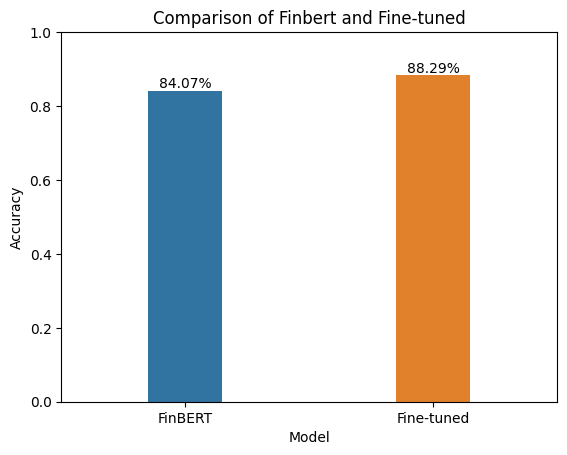

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data_d = pd.DataFrame({'Model': ['FinBERT', 'Fine-tuned'],
                       'Accuracy': [finbert_acc, fine_tuned_model]})

ax = sns.barplot(x='Model', y='Accuracy', width=0.3,data=data_d)


for i, score in enumerate(data_d['Accuracy']):
    plt.annotate("{:.2%}".format(score), (i, score), ha='center', va='bottom')

plt.ylim(0, 1) 
plt.title('Comparison of Finbert and Fine-tuned')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.show()


## Compare with only changed sentences to manual labeling

In [79]:
data_change = data.loc[data.sentence != data.sentence_simple]


In [80]:
data_change.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 1 to 1374
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentence         248 non-null    object
 1   label            248 non-null    int64 
 2   label_pre        248 non-null    int64 
 3   label_new        248 non-null    int64 
 4   sentence_simple  248 non-null    object
 5   focus_ornot      248 non-null    int64 
 6   label_new_s      248 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 15.5+ KB


In [81]:
data_change1 = data.loc[data.label_new != data.label_new_s]


In [82]:
fine_tuned_model_1 = (data_change['label'] == data_change['label_pre']).sum() / len(data_change)

In [83]:
finbert_1 = (data_change['label'] == data_change['label_new']).sum() / len(data_change)

In [84]:
finbert_sf = (data_change['label'] == data_change['label_new_s']).sum() / len(data_change)

In [85]:
data_change.head()

,sentence,label,label_pre,label_new,sentence_simple,focus_ornot,label_new_s
1,Although high profit margins could imply some ...,1,0,1,they might also provide a cushion to absorb so...,1,1
3,Spending on cars and light trucks increased so...,2,2,2,apparently weakened in August.,1,2
5,Higher imports of capital goods excluding airc...,1,1,1,Higher imports of capital goods excluding airc...,0,1
15,Credit outstanding under the Federal Reserve's...,0,1,1,Credit outstanding under the Federal Reserve's...,0,0
24,CDS spreads for banking organizations declined...,0,2,2,CDS spreads for banking organizations declined...,1,2


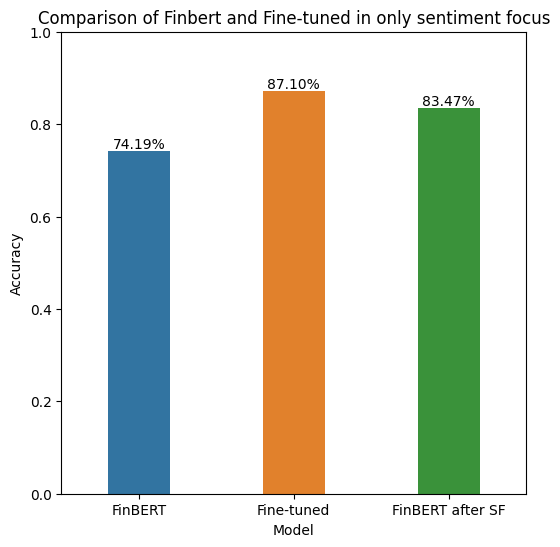

In [156]:
data_s = pd.DataFrame({'Model': ['FinBERT', 'Fine-tuned','FinBERT after SF'],
                     'Accuracy': [finbert_1, fine_tuned_model_1,finbert_sf]})

plt.figure(figsize=(6, 6)) 

sns.barplot(x='Model', y='Accuracy', width=0.4, data=data_s)

bars = ax.patches
hatch_pattern = '////'
for bar in bars:
    bar.set_hatch(hatch_pattern)

for i, score in enumerate(data_s['Accuracy']):
    plt.annotate("{:.2%}".format(score), (i, score), ha='center', va='bottom')

plt.ylim(0, 1) 
plt.title('Comparison of Finbert and Fine-tuned in only sentiment focus')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.show()

## Performance for sentences contains "But"

In [87]:
new_df_but = data_change[data_change['sentence'].str.contains('but')]

In [88]:
data.to_csv('results.csv')

In [89]:
(new_df_but['label'] == new_df_but['label_pre']).sum() / len(new_df_but)

0.8613861386138614

In [90]:
(new_df_but['label'] == new_df_but['label_new']).sum() / len(new_df_but)

0.6732673267326733

In [91]:
(new_df_but['label'] == new_df_but['label_new_s']).sum() / len(new_df_but)

0.8316831683168316

## Performance for sentences contains "while"

In [92]:
new_df_while = data_change[data_change['sentence'].str.contains('while')]

In [93]:
(new_df_while['label'] == new_df_while['label_pre']).sum() / len(new_df_while)

1.0

In [94]:
(new_df_while['label'] == new_df_while['label_new']).sum() / len(new_df_while)

0.875

In [95]:
(new_df_while['label'] == new_df_while['label_new_s']).sum() / len(new_df_while)

0.9375

## Performance for sentences contains "though"

In [96]:
new_df_though = data_change[data_change['sentence'].str.contains('though')]

In [97]:
(new_df_though['label'] == new_df_though['label_pre']).sum() / len(new_df_though)

0.9038461538461539

In [98]:
(new_df_though['label'] == new_df_though['label_new']).sum() / len(new_df_though)

0.7307692307692307

In [99]:
(new_df_though['label'] == new_df_though['label_new_s']).sum() / len(new_df_though)

0.9038461538461539

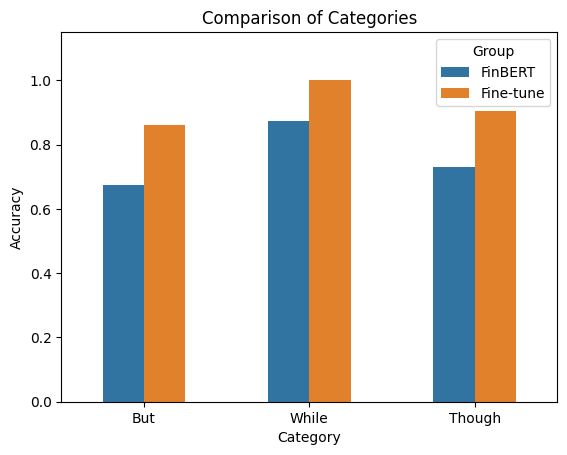

In [159]:
data1 = [(new_df_but['label'] == new_df_but['label_pre']).sum() / len(new_df_but),(new_df_but['label'] == new_df_but['label_new']).sum() / len(new_df_but)]
data2 = [(new_df_while['label'] == new_df_while['label_pre']).sum() / len(new_df_while),(new_df_while['label'] == new_df_while['label_new']).sum() / len(new_df_while)]
data3 = [(new_df_though['label'] == new_df_though['label_pre']).sum() / len(new_df_though),(new_df_though['label'] == new_df_though['label_new']).sum() / len(new_df_though)]

data = pd.DataFrame({'Category': ['But', 'But', 'While', 'While', 'Though', 'Though'],
                     'Group': ['FinBERT', 'Fine-tune','FinBERT', 'Fine-tune','FinBERT', 'Fine-tune'],
                     'Accuracy': [data1[1], data1[0], data2[1], data2[0], data3[1], data3[0]]})

sns.barplot(x='Category', y='Accuracy', width=0.5, hue='Group', data=data)

plt.ylim([0, 1.15])

plt.title('Comparison of Categories')
plt.xlabel('Category')
plt.ylabel('Accuracy')

plt.show()